# Hidden Markov Models (HMMs)

In [77]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---
### Hidden Markov Model

* Random stochastic transitions between a set of discrete states.
* *Memoryless*: Next transition depends only on the current state, not the past history.
* For temporal sequences, transitions are typically exponentially distributed (i.e. rate consant).
* We don't observe the states directly, but instead we observe a probabilistic output (emission) from each state.
* Observations are random variables from probability distributions that may differ for each state.

![](hmm.png)

The probability of getting a particular sequence of observations $O_1, O_2, ...$ is given by

### $\begin{align}
P(O_1, O_2, ...) &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) P(S_1 \rightarrow S_2)  P(S_2 \rightarrow O_2) P(S_2 \rightarrow S_3)  P(S_3 \rightarrow O_3) ... \\
                 &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) \prod_{i \geq 2} P(S_{i-1} \rightarrow S_i)  P(S_i \rightarrow O_i)
\end{align}$

---
### 2-State Markov Model

### State 0 <==> State 1

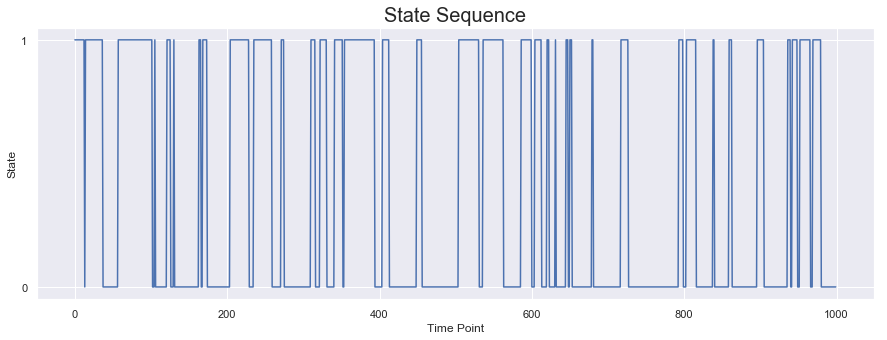

In [96]:
# transition probability matrix for each time step
A = np.array([[0.95, 0.05],   # P(state0->state0), P(state0->state1)
              [0.10, 0.90]])  # P(state1->state0), P(state1->state1)

# initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([0.5, 0.5])     # P(state0), P(state1)

# number of states
n_states = len(p0)

# list of state indices
states = np.arange(n_states)  # [0, 1]

# state sequence for 1000 time points
state_seq = np.zeros(1000, dtype=int)

# set initial state by drawing from initial state probability array
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
# if we are in state0, then we stay in state0 with probability 0.95 and go to state1 with probability 0.05
# if we are in state1, then we stay in state1 with probability 0.90 and go to state0 with probability 0.10
for t in range(1, len(state_seq)):
    state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])

plt.figure(figsize=(15, 5))
plt.plot(state_seq)
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence', fontsize=20);

### Single ion channel gating between closed and open states.

* Interpret the above state sequence as depicting the gating of a single ion channel transitioning between closed and open states.
* Assume we record zero current when the channel is closed (state0), and 5 pA when the channel is open (state1).
* Also assume we have normally distributed noise with std of 1 pA.

0.5

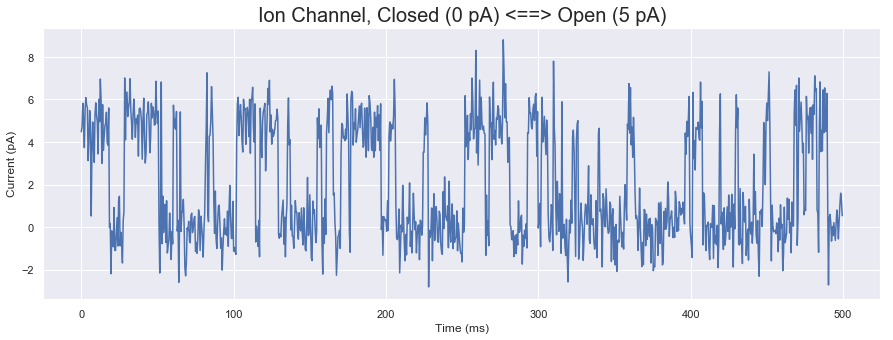

In [97]:
current_pA = state_seq * 5 + np.random.randn(len(state_seq))

sample_freq_kHz = 2
sample_interval_ms = 1 / sample_freq_kHz
time_ms = np.arange(len(current_pA)) * sample_interval_ms

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Ion Channel, Closed (0 pA) <==> Open (5 pA)', fontsize=20)

sample_interval_ms

### The values that we observe when the model is in a given state are random variables from a probability distribution.

* For the above ion channel, we can assign to each state a probability distribution for it to emit an observable (i.e. current).
* In this case, we can assign states 0 and 1 normally distributed current emissions with std 1 pA and means of 0 and 5 pA, respectively.
* But the state emission distributions don't have ot be the same. Let's assume we have std 0.5 pA in the closed state and 1 pA in the open state.

![](hmm.png)

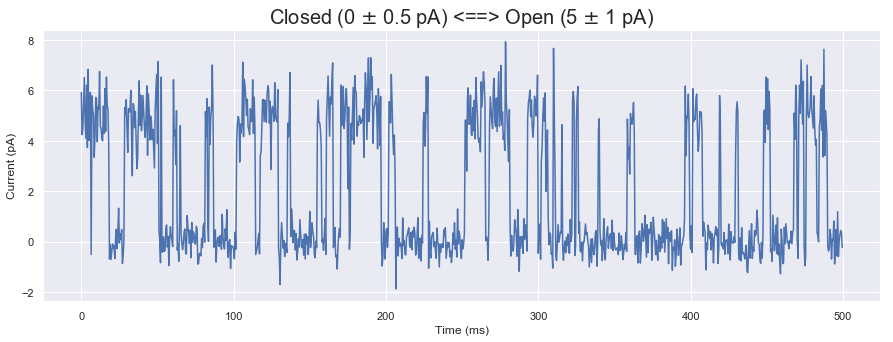

In [98]:
current_pA = np.zeros(state_seq.shape)

closed_pts = np.where(state_seq == 0)[0]
open_pts = np.where(state_seq == 1)[0]

current_pA[closed_pts] = np.random.randn(len(closed_pts)) * 0.5  # closed  0 +/- 0.5 pA
current_pA[open_pts] = 5 + np.random.randn(len(open_pts)) * 1    # open    5 +/- 1.0 pA

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed (0 $\pm$ 0.5 pA) <==> Open (5 $\pm$ 1 pA)', fontsize=20);

---
### 3-State HMM: Closed1 <==> Open <==> Closed2

* Let's add a 2nd closed state to the ion channel 2-State model above, so that we now have two closed states and one open state.
* Both closed states emit the same observable current, i.e. zero current.
* Thus, when we observe zero current, we know that the channel is closed, but we don't know which of the two closed states it is in, or even when it might transition back and forth between the closed states. Thus, the states are hidden.

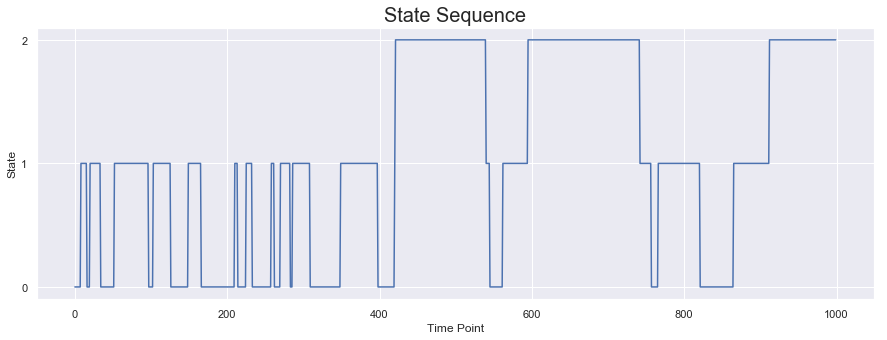

In [99]:
# transition probability matrix for each time step
# closed1 (state0) <==> open (state1) <==> closed2 (state2)
A = np.array([[0.95, 0.05, 0.00],   # P(C1->C1), P(C1->O), P(C1->C2)
              [0.03, 0.95, 0.02],   # P( O->C1), P( O->O), P( O->C2)
              [0.00, 0.005, 0.995]])  # P(C2->C1), P(C2->O), P(C2->C2)

# initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([1, 0, 0])     # P(C1), P(O), P(C2)

# number of states
n_states = len(p0)

# list of state indices
states = np.arange(n_states)  # [0, 1, 2]

# state sequence for 1000 time points
state_seq = np.zeros(1000, dtype=int)

# set initial state by drawing from initial state probability array
np.random.seed(0)
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
# if we are in state0, then we stay in state0 with probability 0.95 and go to state1 with probability 0.05
# if we are in state1, then we stay in state1 with probability 0.90 and go to state0 with probability 0.10
for t in range(1, len(state_seq)):
    state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])

plt.figure(figsize=(15, 5))
plt.plot(state_seq)
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence', fontsize=20);

### Observable current (state emissions).

* Closed and open states pass 0 and 5 pA, respectively.
* Noise is normally distributed with std 0.5 and 1 pA in closed and open states, respectively.

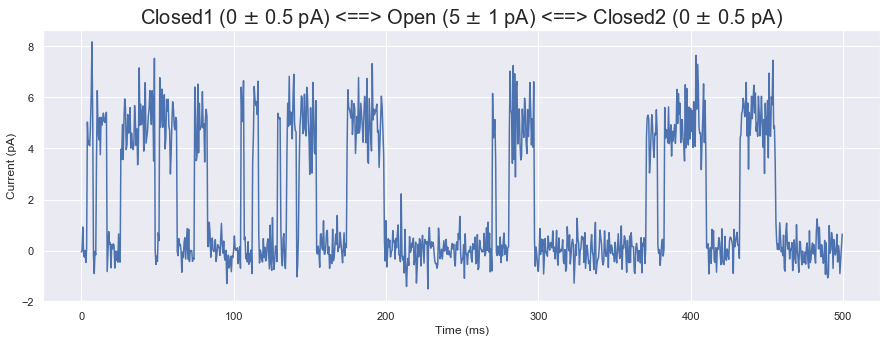

In [100]:
current_pA = np.zeros(state_seq.shape)

closed1_pts = np.where(state_seq == 0)[0]
open_pts = np.where(state_seq == 1)[0]
closed2_pts = np.where(state_seq == 2)[0]

current_pA[closed1_pts] = np.random.randn(len(closed1_pts)) * 0.5  # closed1 = 0 +/- 0.5 pA
current_pA[open_pts] = 5 + np.random.randn(len(open_pts)) * 1      # open = 5 +/- 1 pA
current_pA[closed2_pts] = np.random.randn(len(closed2_pts)) * 0.5  # closed2 = 0 +/- 0.5 pA

plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed1 (0 $\pm$ 0.5 pA) <==> Open (5 $\pm$ 1 pA) <==> Closed2 (0 $\pm$ 0.5 pA)', fontsize=20);

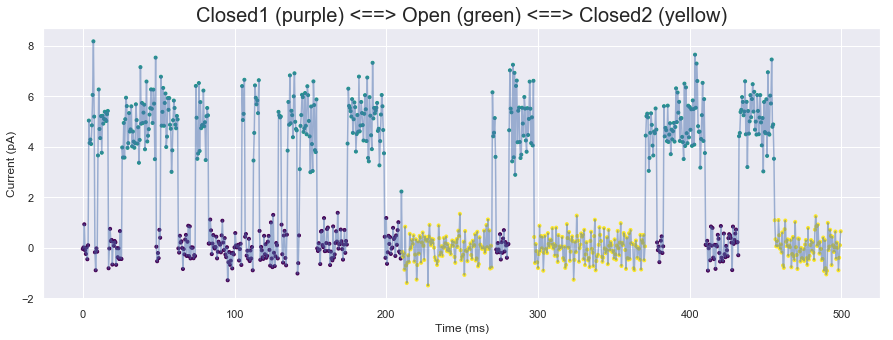

In [101]:
plt.figure(figsize=(15, 5))
plt.plot(time_ms, current_pA, alpha=0.5)
plt.scatter(time_ms, current_pA, c=state_seq, marker='.', cmap='viridis')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Closed1 (purple) <==> Open (green) <==> Closed2 (yellow)', fontsize=20);

---
### Half amplitude threshold idealization.

* Points below threshold are considered closed, above are considred open.

In [102]:
def make_single_channel_record(n_pts, p0, A, B, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    state_seq = np.zeros(n_pts, dtype=int)
    states = np.arange(len(p0))
    state_seq[0] = np.random.choice(states, p=p0)
    for t in range(1, n_pts):
        state_seq[t] = np.random.choice(states, p=A[state_seq[t - 1], :])
    emission = np.zeros(state_seq.shape)
    for i, (mu, sigma) in enumerate(B):
        pts = np.where(state_seq == i)[0]
        emission[pts] = mu + np.random.randn(len(pts)) * sigma
    return state_seq, emission

In [103]:
state_seq, current_pA = make_single_channel_record(1000000, p0, A, [(0, 0.5), (5, 1), (0, 0.5)], random_state=0)

time_ms = np.arange(len(current_pA)) * sample_interval_ms

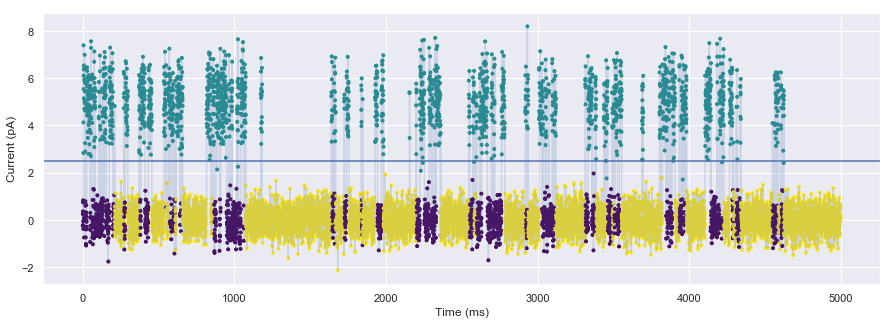

In [104]:
plt.figure(figsize=(15, 5))
n = 10000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.2)
plt.scatter(time_ms[:n], current_pA[:n], marker='.', c=state_seq[:n], cmap='viridis')
plt.axhline(2.5)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

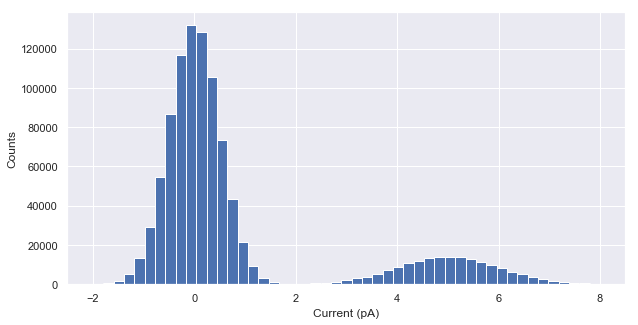

In [105]:
plt.figure(figsize=(10, 5))
plt.hist(current_pA, np.linspace(-2, 8, 50))
plt.xlabel('Current (pA)')
plt.ylabel('Counts');

In [106]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=1)
gmm.fit(current_pA.reshape(-1, 1))

print('amp:', gmm.weights_)
print()
print('mean:', gmm.means_)
print()
print('var', gmm.covariances_)
print()
print('std', np.sqrt(gmm.covariances_))

amp: [0.82512543 0.17487457]

mean: [[-3.78561981e-04]
 [ 4.99887408e+00]]

var [[[0.24925916]]

 [[1.00485671]]]

std [[[0.49925861]]

 [[1.00242541]]]


In [107]:
np.squeeze(gmm.covariances_)

array([0.24925916, 1.00485671])

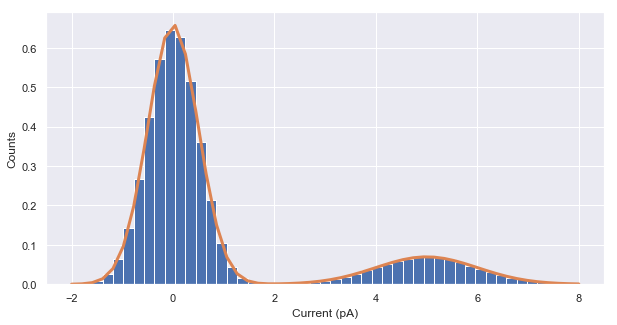

In [108]:
bins = np.linspace(-2, 8, 50)

fit = np.zeros(bins.shape)
for i in range(2):
    amp = gmm.weights_[i]
    mu = np.squeeze(gmm.means_)[i]
    sigma = np.sqrt(np.squeeze(gmm.covariances_)[i])
    fit += amp * st.norm.pdf(bins, mu, sigma)

plt.figure(figsize=(10, 5))
plt.hist(current_pA, bins, density=True)
plt.plot(bins, fit, lw=3)
plt.xlabel('Current (pA)')
plt.ylabel('Counts');

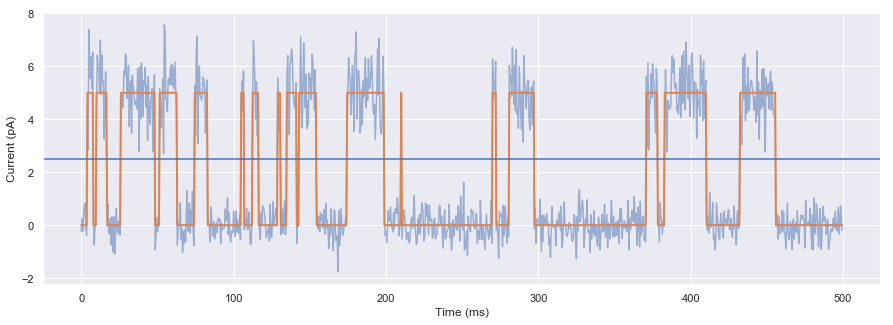

In [109]:
closed_pts = np.where(current_pA < 2.5)[0]
open_pts = np.where(current_pA >= 2.5)[0]

ideal = np.zeros(current_pA.shape)
ideal[open_pts] = 5

plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.plot(time_ms[:n], ideal[:n], lw=2)
plt.axhline(2.5)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

---
### Exponential dwell times

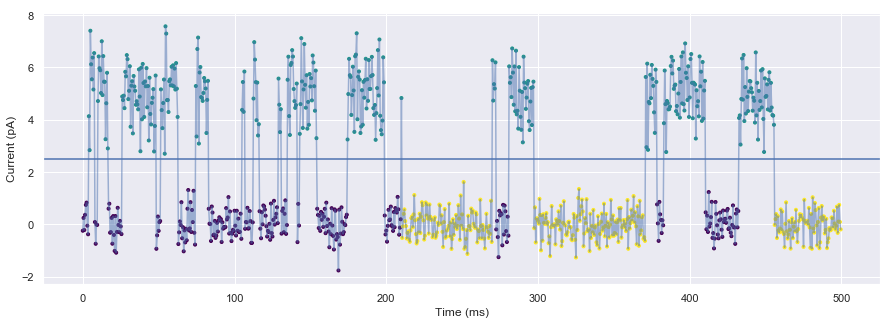

In [110]:
plt.figure(figsize=(15, 5))
n = 1000
plt.plot(time_ms[:n], current_pA[:n], alpha=0.5)
plt.scatter(time_ms[:n], current_pA[:n], marker='.', c=state_seq[:n], cmap='viridis')
plt.axhline(2.5)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');

In [111]:
ideal[:9], np.diff(ideal[:9])

(array([0., 0., 0., 0., 0., 0., 0., 0., 5.]),
 array([0., 0., 0., 0., 0., 0., 0., 5.]))

In [112]:
co_pts = np.where(np.diff(ideal) == 5)[0]
oc_pts = np.where(np.diff(ideal) == -5)[0]

co_pts[:9], oc_pts[:9]

(array([  7,  19,  51, 102, 148, 209, 224, 257, 269]),
 array([ 15,  33,  96, 125, 165, 213, 232, 261, 282]))

In [113]:
N = min(len(co_pts), len(oc_pts))

open_durations_pts = oc_pts[:N] - co_pts[:N]
closed_durations_pts = co_pts[1:N] - oc_pts[:N-1]

open_durations_pts[:9], closed_durations_pts[:9]

(array([ 8, 14, 45, 23, 17,  4,  8,  4, 13]),
 array([ 4, 18,  6, 23, 44, 11, 25,  8,  3]))

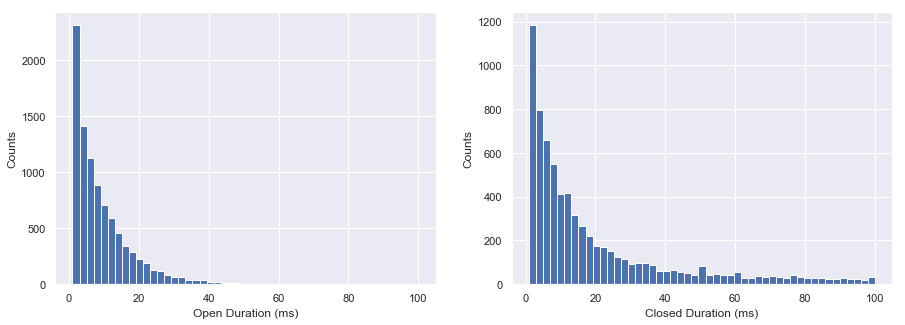

In [115]:
open_durations_ms = open_durations_pts * sample_interval_ms
closed_durations_ms = closed_durations_pts * sample_interval_ms

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(open_durations_ms, np.linspace(1, 100, 50))
plt.xlabel('Open Duration (ms)')
plt.ylabel('Counts')

plt.subplot(122)
plt.hist(closed_durations_ms, np.linspace(1, 100, 50))
plt.xlabel('Closed Duration (ms)')
plt.ylabel('Counts');

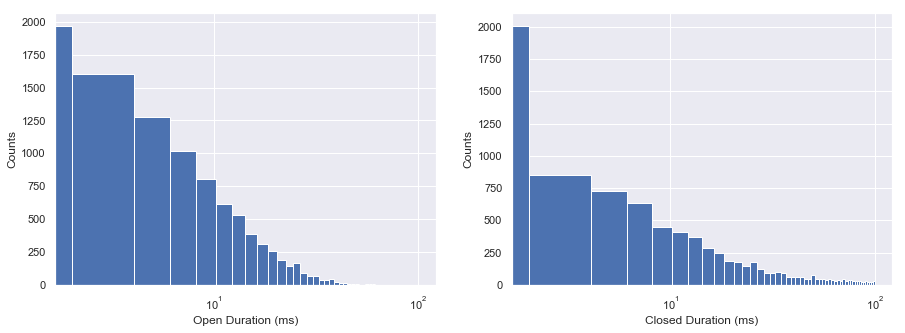

In [116]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(open_durations_ms, np.linspace(0, 100, 50))
plt.xscale('log')
plt.xlabel('Open Duration (ms)')
plt.ylabel('Counts')

plt.subplot(122)
plt.hist(closed_durations_ms, np.linspace(0, 100, 50))
plt.xscale('log')
plt.xlabel('Closed Duration (ms)')
plt.ylabel('Counts');

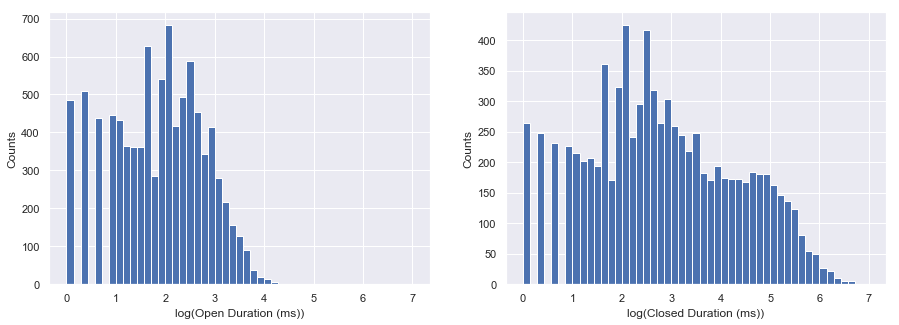

In [130]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(np.log(open_durations_ms), np.linspace(0, 7, 50))
plt.xlabel('log(Open Duration (ms))')
plt.ylabel('Counts')

plt.subplot(122)
plt.hist(np.log(closed_durations_ms), np.linspace(0, 7, 50))
plt.xlabel('log(Closed Duration (ms))')
plt.ylabel('Counts');

### Maximum likelihood exponential fitting of dwell time distributuions.

In [118]:
# fit open durations to a single exponential distribution
_, open_tau_ms = st.expon.fit(open_durations_ms, floc=0)

open_tau_ms, np.log(open_tau_ms)

(8.927749229188079, 2.189164317115901)

In [119]:
# fit closed durations to a biexponential distribution (i.e. weighted sum of two exponential distributions)
import scipy.optimize as opt

def biexp_pdf(t, params):
    A1, tau1_ms, tau2_ms = params
    return A1 * st.expon.pdf(t, 0, tau1_ms) + (1 - A1) * st.expon.pdf(t, 0, tau2_ms)

def closed_durations_biexp_negLL(params):
    pdf = biexp_pdf(closed_durations_ms, params)
    return -np.log(pdf).sum()

bnds = opt.Bounds([0, 1, 1], [1, 1000, 1000])  # lower bounds, upper bounds
result = opt.minimize(closed_durations_biexp_negLL, [0.5, 10, 100], method='slsqp', bounds=bnds)
print(result)

     fun: 42760.586306756886
     jac: array([ 0.01757812, -0.00048828, -0.00048828])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 0.61055302,  7.57165399, 97.12283026])


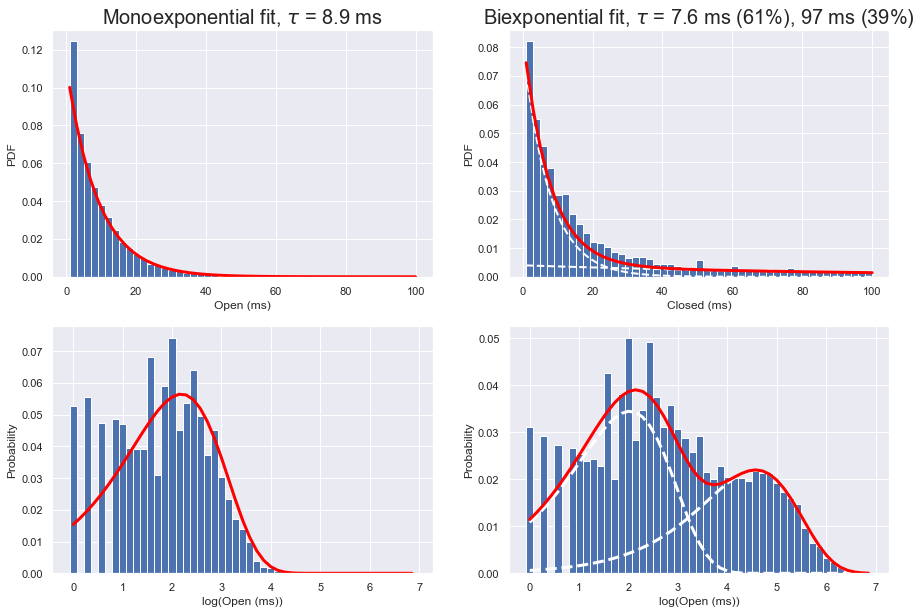

In [131]:
# parameters for closed durations fit
closed_A1, closed_tau1_ms, closed_tau2_ms = result.x
closed_A2 = 1 - closed_A1

plt.figure(figsize=(15, 10))

plt.subplot(221)
bins = np.linspace(1, 100, 50)
plt.hist(open_durations_ms, bins, density=True)
plt.plot(bins, st.expon.pdf(bins, 0, open_tau_ms), lw=3, color='red')
plt.xlabel('Open (ms)')
plt.ylabel('PDF')
plt.title(r'Monoexponential fit, $\tau$ = 8.9 ms', fontsize=20)

plt.subplot(222)
bins = np.linspace(1, 100, 50)
plt.hist(closed_durations_ms, bins, density=True)
plt.plot(bins, closed_A1 * st.expon.pdf(bins, 0, closed_tau1_ms), '--', lw=2, color='white')
plt.plot(bins, closed_A2 * st.expon.pdf(bins, 0, closed_tau2_ms), '--', lw=2, color='white')
plt.plot(bins, biexp_pdf(bins, result.x), lw=3, color='red')
plt.xlabel('Closed (ms)')
plt.ylabel('PDF')
plt.title(r'Biexponential fit, $\tau$ = 7.6 ms (61%), 97 ms (39%)', fontsize=20)

plt.subplot(223)
logbins = np.linspace(0, 7, 50)
logbinwidth = logbins[1] - logbins[0]
bins = np.exp(logbins)
binwidths = np.diff(bins)
# probability = pdf * binwidths
pdf, edges = np.histogram(open_durations_ms, bins, density=True)
plt.bar(logbins[:-1], pdf.astype(float) * binwidths, width=logbinwidth)
# fit probability = pdf * binwidths
pdf = st.expon.pdf(bins[:-1], 0, open_tau_ms)
plt.plot(logbins[:-1], pdf * binWidths, lw=3, color='red')
plt.xlabel('log(Open (ms))')
plt.ylabel('Probability')

plt.subplot(224)
logbins = np.linspace(0, 7, 50)
logbinwidth = logbins[1] - logbins[0]
bins = np.exp(logbins)
binwidths = np.diff(bins)
# probability = pdf * binwidths
pdf, edges = np.histogram(closed_durations_ms, bins, density=True)
plt.bar(logbins[:-1], pdf.astype(float) * binwidths, width=logbinwidth)
# fit probability = pdf * binwidths
pdf = closed_A1 * st.expon.pdf(bins[:-1], 0, closed_tau1_ms)
plt.plot(logbins[:-1], pdf * binWidths, '--', lw=3, color='white')
pdf = closed_A2 * st.expon.pdf(bins[:-1], 0, closed_tau2_ms)
plt.plot(logbins[:-1], pdf * binWidths, '--', lw=3, color='white')
pdf = biexp_pdf(bins[:-1], [closed_A1, closed_tau1_ms, closed_tau2_ms])
plt.plot(logbins[:-1], pdf * binWidths, lw=3, color='red')
plt.xlabel('log(Open (ms))')
plt.ylabel('Probability');

### Rate constant for leaving a state is the inverse of the time constant for dwelling in that state.

### $k = \frac{1}{\tau}$

In [ ]:
hmm fitting
postulate states
viterbi
baum-welch